In [1]:
import numpy as np 
import pandas as pd 
import time
import orca 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

from sklearn.model_selection import KFold, train_test_split
from statsmodels.discrete.discrete_model import MNLogit

In [2]:
hdf = pd.HDFStore('output/pipeline.h5')
pp = hdf['/persons/trip_mode_choice']
hh = hdf['/households/trip_mode_choice']
tours = hdf['/tours/trip_mode_choice']
trips = hdf['/trips/trip_mode_choice']
acc = hdf['/accessibility/trip_mode_choice']
lu = hdf['/land_use/trip_mode_choice']

print ('Number of Households: ',hh.shape[0])
print ('Number of Persons: ',pp.shape[0])
print ('Number of tours: ',tours.shape[0])
print ('Number of trips: ',trips.shape[0])

Number of Households:  20000
Number of Persons:  49559
Number of tours:  66151
Number of trips:  169966


In [3]:
def simulation(probs):
    rands = np.random.rand(len(probs),1,)
    probs_arr = probs.values.cumsum(axis=1) - rands
    choices = np.argmax(probs_arr > 0.0, axis=1)
    choices = pd.Series(choices, index=probs.index)
    return choices

In [4]:
def car_ownership_validation(hh):
    ''' Validation tool for car ownership model
    Input: Dataframe with columns VEHCL: Real number of vehicles, 
           and 'auto_ownership': predicted household car ownership. 
    Output: Plots of carownership by TAZ. 
    '''
    # Auto ownership by TAZ 
    hh['0'] = hh['auto_ownership'] == 0
    hh['1'] = hh['auto_ownership'] == 1
    hh['2'] = hh['auto_ownership'] == 2
    hh['3'] = hh['auto_ownership'] == 3
    hh['4'] = hh['auto_ownership'] == 4

    auto_asim = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum' })
    auto_asim.reset_index(inplace = True)

    auto_asim = pd.melt(auto_asim, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    #VEHCL by TAZ 
    hh['0'] = hh['VEHICL'] == 0
    hh['1'] = hh['VEHICL'] == 1
    hh['2'] = hh['VEHICL'] == 2
    hh['3'] = hh['VEHICL'] == 3
    hh['4'] = hh['VEHICL'] >= 4

    auto_tm1 = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum', })
    auto_tm1.reset_index(inplace = True)

    auto_tm1 = pd.melt(auto_tm1, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    # Merge ativitysim and validation results in one table
    auto = auto_asim.merge(auto_tm1, how = 'inner', on = ['TAZ', 'variable'], suffixes=('_asim', '_tm1'))
    auto.columns = ['TAZ', 'Auto ownership', 'ActivitySim', 'MTC']
    
    #Plot
    g = sns.lmplot('MTC','ActivitySim', auto,col = 'Auto ownership',sharex = False,sharey = False,
               markers='o', height=5, aspect=0.8, x_jitter=.1, col_wrap=3,
              scatter_kws={"s": 20, "edgecolor": 'k', "alpha": 0.5})

    g.fig.suptitle("TAZ-to-TAZ Car ownerwhip \n MTC vs ActivitySim", y=1.05, fontsize = 15);

In [5]:
def add_simulation_vars(households, accessibilities, land_use):
    
    #Merge accesibilities and land use variables 
    hh_merge = hh.merge(accessibilities, how = 'inner', left_on = 'TAZ', right_index = True).\
              merge(land_use, how = 'inner', left_on = 'TAZ', right_index = True)
    
    #Household-based variables 
    hh_merge['num_drivers_2'] = hh_merge.num_drivers == 2
    hh_merge['num_drivers_3'] = hh_merge.num_drivers == 3
    hh_merge['num_drivers_4+'] = hh_merge.num_drivers > 3
    hh_merge['children_0_4'] = hh_merge.num_young_children > 0
    hh_merge['children_5_17'] = (hh_merge.num_children_5_to_15 + hh_merge.num_children_16_to_17)>0
    hh_merge['num_workes_3'] = hh_merge.num_workers.clip(upper = 3)
    hh_merge['income_30'] = hh_merge.income_in_thousands.clip(0,30)
    hh_merge['income_75'] = (hh_merge.income_in_thousands-30).clip(0,45)
    hh_merge['income_125'] = (hh_merge.income_in_thousands-75).clip(0,50)
    
    #Household and land_use-based variables 
    hh_merge['density_10_0w'] = (hh_merge.num_workers == 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['density_+10_0w'] = (hh_merge.num_workers == 0)*(hh_merge.density_index-10).clip(0)
    hh_merge['density_10_+1w'] = (hh_merge.num_workers > 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['density_+10_+1w'] = (hh_merge.num_workers > 0)*(hh_merge.density_index-10).clip(0)
    hh_merge['constant'] = 1
    
    #Accessibility_based variables
    hh_merge['retail_0w_auto'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['retail_+1w_auto'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['retail_0w_transit'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['retail_+1w_transit'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['retail_0w_nm'] = (hh_merge.num_workers == 0)*hh_merge.nmRetail
    hh_merge['retail_+1w_nm'] = (hh_merge.num_workers > 0)*hh_merge.nmRetail
    hh_merge['auto_saving_work'] = np.where(hh_merge.num_workers > 0, 
                                      hh_merge.hh_work_auto_savings_ratio/hh_merge.num_workers, 
                                      0)
    
    hh_merge['cars'] = hh_merge.VEHICL.where(hh_merge.VEHICL < 4, 4)
    return hh_merge

In [6]:
hh_merge = add_simulation_vars(hh, acc, lu) 

## Grid search 
This part will take care of the grid search
- Create arrays for each parameter that will be included in the serach. Array is the parameter range for evaluation 
- Built random set combinations of coefficients (All combinations take a lot to run) 
- Run simulation with random set of coefficients and store score result
- Organize scores in a table to compare results

In [7]:
var_names = ['num_drivers_2', 'num_drivers_3', 'num_drivers_4+', 'num_children_16_to_17',
             'num_college_age', 'num_young_adults', 'children_0_4', 'children_5_17',
             'num_workes_3', 'income_30', 'income_75', 'income_125', 'density_10_0w',
             'density_+10_0w','density_10_+1w', 'density_+10_+1w','constant', 
             'retail_0w_auto','retail_+1w_auto', 'retail_0w_transit','retail_+1w_transit', 
             'retail_0w_nm', 'retail_+1w_nm', 'auto_saving_work']


# Read csv file 
coeff = pd.read_csv('configs/auto_ownership.csv')
coeff = coeff.fillna(0)[['cars0', 'cars1', 'cars2', 'cars3', 'cars4']]
coeff.index = var_names

In [10]:
def grid_search(var_to_replace, coeff, hh_merge, var_names, iterations = 100):
    '''
    Grid-like search algortihm to estimate the best parameters to maximize prediction of car ownership share
    Input: 
    - var_to_replace: list of 12 arrays. Each array contains the range for each coefficient. 
                    List in the following order: 
                    0. Constant 1_car
                    1. Constant 2_car
                    2. Constant 3_car
                    3. Constant 4_car
                    4. driver_2 1_car
                    5. driver_2 2_car
                    6. driver_2 3_car
                    7. driver_2 4_car
                    8. driver_3 1_car
                    9. driver_3 2_car
                    10. driver_3 3_car
                    11. driver_3 4_car
    - coeff: The coefficients dataframe
    - hh_merge: choosers
    - var_name: should be coefficient indexes and all var should be in hh_merge
    - iteration: Number of random sets for the gris like-search (since there are a lot of options,I select some of them)
    
    Return 
    Dataframe. Each row with one combination of the 12 varaibles, and the corresponding score. 
    '''
    #Generate random set of coefficients 
    sample_list = []
    for var in vars_to_replace:
        random_sample = np.random.choice(var, iterations, replace = True)
        sample_list.append(random_sample)

    grid_rands = np.array(sample_list).T
    
    score_list = []
    for row in grid_rands:
    #     start = time.time()
        coeff.loc['constant','cars1'] = row[0]
        coeff.loc['constant','cars2'] = row[1]
        coeff.loc['constant','cars3'] = row[2]
        coeff.loc['constant','cars4'] = row[3]
        
        coeff.loc['num_drivers_2','cars1'] = row[4]
        coeff.loc['num_drivers_2','cars2'] = row[5]
        coeff.loc['num_drivers_2','cars3'] = row[6]
        coeff.loc['num_drivers_2','cars4'] = row[7]

        coeff.loc['num_drivers_3','cars1'] = row[8]
        coeff.loc['num_drivers_3','cars2'] = row[9]
        coeff.loc['num_drivers_3','cars3'] = row[10]
        coeff.loc['num_drivers_3','cars4'] = row[11]

        # MNL and simulation
        utils = (hh_merge[var_names] @ coeff).astype(float)
        utils_exp = utils.apply(np.exp)
        probs = utils_exp.div(utils_exp.sum(axis = 1), axis = 0)
        choices = simulation(probs)
        hh_merge['auto_ownership'] = choices 

        #Score
#         score = ((hh_merge['cars'] - hh_merge['auto_ownership'])**2).sum()/hh_merge.shape[0]
    #     score = sklearn.metrics.f1_score(hh_merge['cars'], hh_merge['auto_ownership'], average = 'weighted')
    #     cross_tab = pd.crosstab(hh_merge.VEHICL, hh_merge.auto_ownership, normalize= 'all')
    #     score = np.diagonal(cross_tab).sum()

        score = np.abs((hh_merge.cars.value_counts() -  hh_merge.auto_ownership.value_counts())).sum()
        score_list.append(score)
    #     end = time.time()
    #     print(end - start)
    
    results_join = pd.DataFrame(grid_rands)
    results_join['score'] = score_list
    
    return results_join
    

In [91]:
#Initial values:
var0 = np.linspace(0,5,11)
var1 = np.linspace(0,5,11)
var2 = np.linspace(-5,0,11)
var3 = np.linspace(-5,0,11)

var4 = np.linspace(-1,0,101)
var5 = np.linspace(3.0773 - 0.47,3.0773 + 0.47,11)
var6 = np.linspace(3.1962 - 0.48,3.1962 + 0.48,11)
var7 = np.linspace(2.6616 - 0.40,2.6616 + 0.400,11)

var8 = np.linspace(-2,0,11)
var9 = np.linspace(3.5401 - 0.54,3.5401 + 0.54,11)
var10 = np.linspace(5.513 - 0.83,5.5131 - 0.83,11)
var11 = np.linspace(5.208 - 0.79,5.2080 + 0.79,11)

vars_to_replace = [var0, var1, var2, var3, var4, var5, var6, var7, var8, var9, var10, var11]

In [106]:
#Final range search
var0 = np.linspace(4.3,4.5,101)
var1 = np.linspace(1.5,1.8,101)
var2 = np.linspace(-0.5,-0.3,101)
var3 = np.linspace(-2.7,-2.5,101)

var4 = np.linspace(-1,-0.7,101)
var5 = np.linspace(3.1,3.4,101)
var6 = np.linspace(2.9,3.3,101)
var7 = np.linspace(2.6, 3.0,101)

var8 = np.linspace(-2.3,-1.6,101)
var9 = np.linspace(3.4, 3.8,101)
var10 = np.linspace(4.6, 4.7,101)
var11 = np.linspace(4.8,5.2,101)

vars_to_replace = [var0, var1, var2, var3, var4, var5, var6, var7, var8, var9, var10, var11]

In [107]:
%%time
grid_results = grid_search(vars_to_replace, coeff, hh_merge, var_names, iterations = 1000)

CPU times: user 1min 54s, sys: 480 ms, total: 1min 54s
Wall time: 1min 54s


In [108]:
grid_results.sort_values('score').head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,score
110,4.372,1.551,-0.430,-2.654,-0.826,3.385,3.152,2.904,-2.216,3.480,4.650,4.988,108
720,4.460,1.671,-0.350,-2.568,-0.823,3.361,3.280,2.860,-2.041,3.632,4.609,5.176,114
810,4.438,1.668,-0.404,-2.586,-0.880,3.277,3.140,2.880,-2.104,3.548,4.678,5.092,134
617,4.492,1.785,-0.440,-2.586,-0.964,3.103,3.240,2.956,-1.740,3.560,4.640,4.864,140
65,4.436,1.572,-0.358,-2.558,-0.955,3.313,2.976,2.712,-2.076,3.508,4.695,4.960,150
865,4.436,1.542,-0.484,-2.638,-0.979,3.367,3.148,2.888,-1.754,3.576,4.663,5.196,188
869,4.392,1.749,-0.364,-2.566,-0.865,3.121,3.044,2.860,-2.027,3.484,4.688,5.200,194
901,4.424,1.698,-0.376,-2.594,-0.886,3.127,2.976,2.900,-2.167,3.584,4.687,4.956,194
970,4.356,1.614,-0.466,-2.644,-0.811,3.364,3.208,2.988,-1.761,3.508,4.699,4.848,202
433,4.428,1.716,-0.460,-2.660,-0.886,3.139,3.232,2.992,-1.705,3.652,4.700,5.160,208


In [ ]:
best_coeff = [4.372, 1.551, -0.430, -2.654, 
              -0.826, 3.385, 3.152, 2.904, 
              -2.216, 3.480, 4.650, 4.988]

   cars  auto_ownership  diff
2  8667            8689   -22
1  7143            7073    70
3  2574            2539    35
4   888             883     5
0   728             816   -88
-------------------------------------------------
auto_ownership    0     1     2     3    4
cars                                      
0                73   432   181    32   10
1               450  4490  1730   369  104
2               221  1798  5059  1255  334
3                62   253  1366   617  276
4                10   100   353   266  159


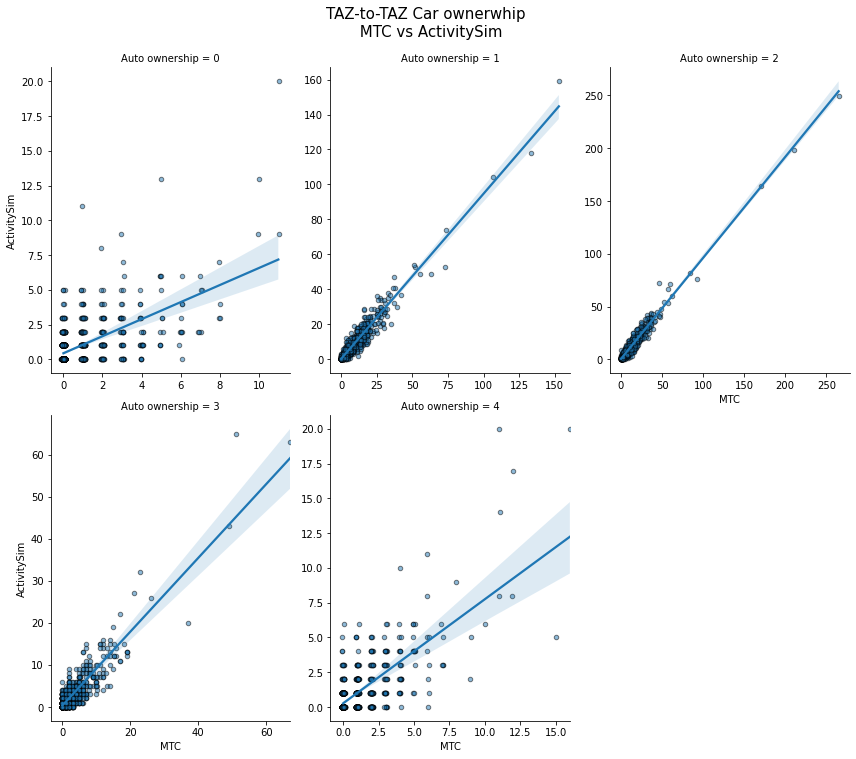

In [124]:
best_coeffs = grid_results[grid_results.score == grid_results.score.min()]
coeff.loc['constant','cars1'] = best_coeffs.iloc[0,0]
coeff.loc['constant','cars2'] = best_coeffs.iloc[0,1]
coeff.loc['constant','cars3'] = best_coeffs.iloc[0,2]
coeff.loc['constant','cars4'] = best_coeffs.iloc[0,3]

coeff.loc['num_drivers_2','cars1'] = best_coeffs.iloc[0,4]
coeff.loc['num_drivers_2','cars2'] = best_coeffs.iloc[0,5]
coeff.loc['num_drivers_2','cars3'] = best_coeffs.iloc[0,6]
coeff.loc['num_drivers_2','cars4'] = best_coeffs.iloc[0,7]

coeff.loc['num_drivers_3','cars1'] = best_coeffs.iloc[0,8]
coeff.loc['num_drivers_3','cars2'] = best_coeffs.iloc[0,9]
coeff.loc['num_drivers_3','cars3'] = best_coeffs.iloc[0,10]
coeff.loc['num_drivers_3','cars4'] = best_coeffs.iloc[0,11]

 # MNL and simulation
utils = (hh_merge[var_names] @ coeff).astype(float)
utils_exp = utils.apply(np.exp)
probs = utils_exp.div(utils_exp.sum(axis = 1), axis = 0)
choices = simulation(probs)
hh_merge['auto_ownership'] = choices 

comparison = pd.concat((hh_merge['cars'].value_counts(), hh_merge['auto_ownership'].value_counts()), axis = 1)
comparison['diff'] = comparison['cars'] - comparison['auto_ownership']
print(comparison)
print('-------------------------------------------------')
print(pd.crosstab(hh_merge.cars, hh_merge.auto_ownership))#, normalize= 'index')
car_ownership_validation(hh_merge)

Best coefficients are: 

Note: Best coefficients can change everytime the simulaiton is run, but the variation is not significant. 

In [13]:
best_coeff = [4.372, 1.551, -0.430, -2.654, 
              -0.826, 3.385, 3.152, 2.904, 
              -2.216, 3.480, 4.650, 4.988]